# LeNet and AlexNet

Given knowledge of CNNs: how are these individual CNN layers combined into a deep learning model? The LeNet architecture is one of the first CNN archiectures.

AlexNet is a deep CNN (DCNN) that holds a similar structure to LeNet, but adds modernized differences in activation function, depth, pooling, and dropout.

This notebook will explore both CNNs, their differences, and introduce a framework of memory and compute analysis that will be used for other deep CNNs.

Additionally, as architectures get deeper between LeNet and AlexNet, it is recommended to follow through the notebook with GPU access.

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install numpy
!pip install d2l

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.0 MB/s  0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> No available output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
ERROR: Failed to build 'numpy' when getting requirements to build wheel


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

ModuleNotFoundError: No module named 'd2l'

In [ ]:
import torch
from torch import nn
import numpy as np
import random
import os

def set_pytorch_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_pytorch_seed()

In [33]:
def evaluate_model(model, data_loader):
    metric = d2l.Accumulator(2)
    model.eval()
    # Get the device of the model's parameters (assuming model is already on the correct device)
    device = next(model.parameters()).device
    with torch.no_grad():
        for X, y in data_loader:
            # Move input data and labels to the same device as the model
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel()) # Changed to d2l.torch.accuracy
    return metric[0] / metric[1]

In [22]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [23]:
accuracies = {}
training_times = {}
parameter_count = {}

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
import time

def train_and_eval(model, name, epochs=10, batchsize=128, resize=False):
  if resize:
    data = d2l.FashionMNIST(batch_size=batchsize, resize=(224, 224)) # Changed to d2l.data.FashionMNIST
  else:
    data = d2l.FashionMNIST(batch_size=batchsize) # Changed to d2l.data.FashionMNIST

  # Explicitly move the model to GPU if available
  if torch.cuda.is_available():
      model = model.to(torch.device('cuda'))

  trainer = d2l.Trainer(max_epochs=epochs, num_gpus=1) # Changed to d2l.torch.Trainer # num_gpus=1 tells trainer to use GPU

  # The initial forward pass for Lazy layers needs the input on the correct device
  dummy_input = next(iter(data.val_dataloader()))[0]
  if torch.cuda.is_available():
      dummy_input = dummy_input.to(torch.device('cuda'))
  model.forward(dummy_input)

  model.apply(init_cnn)

  start = time.perf_counter()
  trainer.fit(model, data) # Trainer should handle moving data to GPU during training
  end = time.perf_counter()

  accuracies[name] = evaluate_model(model, data.val_dataloader())
  training_times[name] = end - start
  parameter_count[name] = count_parameters(model)
  average_time_per_epoch = (end - start) / epochs # Calculate average time first
  print(f"Average time per epoch: {average_time_per_epoch:.4f} seconds") # Then format the result
  print(f"Accuracy: {accuracies[name]}")
  print(f"Parameter count: {parameter_count[name]}")

## LeNet
LeNet-5 was developed in 1998 for a digit image classification task and is promising for our Fashion MNIST classification task. Both datasets act on 28x28 pixel images and LeNet represents a classic CNN that is similar to the distributed scanning CNN developed in the CNN notebook.

By "classic CNN", the LeNet-5 architecture consists of convolutional layers followed by unrolling and an MLP layer. Each convolution is followed by downsampling and activation functions. In the original LeNet architecture, the activation function is a Gaussian function. For simplification, this implementation replaces it with a Sigmoid function. Otherwise, all else is the same.

In [45]:
class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10, pool=nn.AvgPool2d, actfn=nn.Sigmoid, dropout=None):
        super().__init__()
        self.save_hyperparameters()

        # If no dropout is provided, use Identity
        dropout_layer = dropout if dropout is not None else nn.Identity()

        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), actfn(),
            pool(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), actfn(),
            pool(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), actfn(), dropout_layer,
            nn.LazyLinear(84), actfn(), dropout_layer,
            nn.LazyLinear(num_classes))

Average time per epoch: 10.6417 seconds
Accuracy: 0.7152
Parameter count: 61706


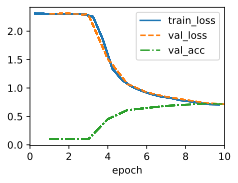

In [36]:
train_and_eval(LeNet(), "LeNet")

## AlexNet

In [40]:
class AlexNet(d2l.Classifier): # Changed to d2l.torch.Classifier
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn) # Changed to d2l.torch.init_cnn

Average time per epoch: 63.1816 seconds
Accuracy: 0.9188
Parameter count: 46764746


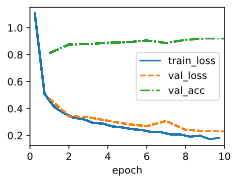

In [41]:
train_and_eval(AlexNet(), "AlexNet", resize=True)

## LeNet to AlexNet

Average time per epoch: 10.7351 seconds
Accuracy: 0.7298
Parameter count: 61706


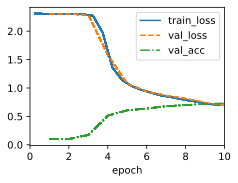

In [42]:
train_and_eval(LeNet(pool=nn.MaxPool2d), "LeNet-MaxPool")

Average time per epoch: 11.0362 seconds
Accuracy: 0.8748
Parameter count: 61706


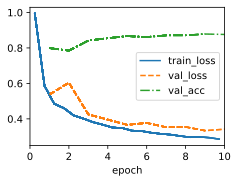

In [46]:
train_and_eval(LeNet(actfn=nn.ReLU), "LeNet-ReLU")

Average time per epoch: 10.9009 seconds
Accuracy: 0.1
Parameter count: 61706


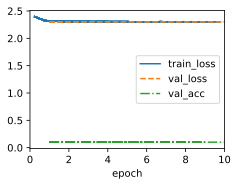

In [47]:
train_and_eval(LeNet(dropout=nn.Dropout(p=0.5)), "LeNet-ReLU")

## Epochs

Average time per epoch: 10.9455 seconds
Accuracy: 0.8033
Parameter count: 61706


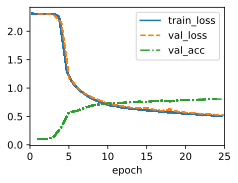

In [48]:
train_and_eval(LeNet(), "LeNet-Long", epochs=25)

Average time per epoch: 63.2844 seconds
Accuracy: 0.9226
Parameter count: 46764746


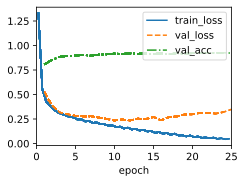

In [49]:
train_and_eval(AlexNet(), "AlexNet-Long", resize=True, epochs=25)

## Training Efficiency

In [50]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [51]:
class AlexNet_smaller(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(16, kernel_size=5, stride=2, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(216), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(216), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [52]:
AlexNet_smaller().layer_summary((1, 1, 24, 24))

Conv2d output shape:	 torch.Size([1, 16, 11, 11])
ReLU output shape:	 torch.Size([1, 16, 11, 11])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Conv2d output shape:	 torch.Size([1, 32, 5, 5])
ReLU output shape:	 torch.Size([1, 32, 5, 5])
MaxPool2d output shape:	 torch.Size([1, 32, 2, 2])
Conv2d output shape:	 torch.Size([1, 64, 2, 2])
ReLU output shape:	 torch.Size([1, 64, 2, 2])
Conv2d output shape:	 torch.Size([1, 64, 2, 2])
ReLU output shape:	 torch.Size([1, 64, 2, 2])
Conv2d output shape:	 torch.Size([1, 32, 2, 2])
ReLU output shape:	 torch.Size([1, 32, 2, 2])


RuntimeError: Given input size: (32x2x2). Calculated output size: (32x0x0). Output size is too small

In [ ]:
train_and_eval(AlexNet_smaller(), "AlexNet-Smaller")

## Batch Size

In [ ]:
train_and_eval(AlexNet(), "AlexNet-Batch32", resize=True, batchsize=32)

In [ ]:
train_and_eval(AlexNet(), "AlexNet-Batch256", resize=True, batchsize=256)